In [1]:
import re
import datetime
import urllib.request
import io
import math
from datetime import date
import json

import torch
from Bio import Phylo
import pandas as pd
import matplotlib.pyplot as plt
from augur.utils import json_to_tree

import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel
from pyro.contrib.epidemiology.models import SuperspreadingSEIRModel
from pyro.contrib.epidemiology.distributions import binomial_dist, infection_dist

pyro.enable_validation(True)
torch.set_default_dtype(torch.double)
torch.set_printoptions(precision=2)
print(torch.__version__)
print(pyro.__version__)

1.6.0
1.4.0


# Information Parsing
<hr>

### Parse timetree phylogeny and find clades

In [11]:
# with auspice JSONs
region = "california"
tree_json = f"../jsons/ncov_{region}.json"
tree_newick = f"../newicks/tree_{region}_time.nwk"

def get_phylogeny(tree_path, tree_type="newick"):
    if tree_type == "newick":   
        with open(tree_newick) as f:
            for phylogeny in Phylo.parse(f, "newick"):
                break
            return phylogeny
    
    elif tree_type == "auspice_json":
        with open(tree_json) as f:
                tree = json.load(f)

        phylogeny = json_to_tree(tree)
        return phylogeny
    
    else:
        raise ValueError(
            f"current tree_type {tree_type} not supported"
        )
    
phylogeny_auspice = get_phylogeny(tree_json, tree_type="auspice_json")
phylogeny_newick = get_phylogeny(tree_newick, tree_type="newick")

In [14]:
# Fix a parsing error for whereby internal nodes interpret .name as .confidence
def fix_parsing_annotations(phylogeny):
    for clade in phylogeny.find_clades():
        if clade.confidence:
            clade.name = clade.confidence
            clade.confidence = None
            
fix_parsing_annotations(phylogeny_auspice)
fix_parsing_annotations(phylogeny_newick)

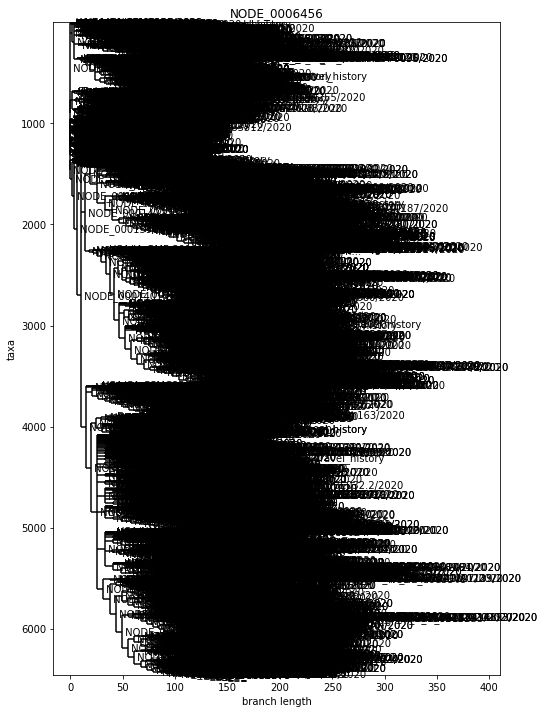

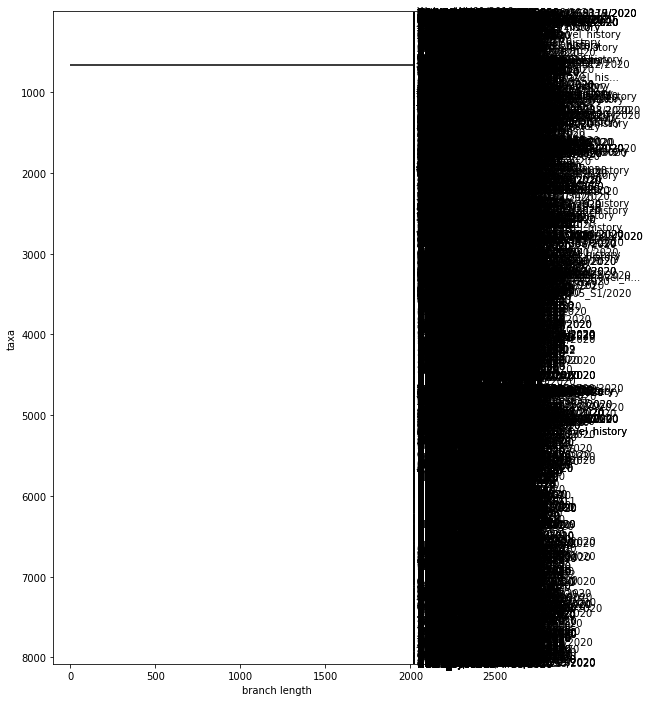

In [15]:
def draw_phylogeny(phylogeny):
    Phylo.draw(phylogeny, do_show=False)
    plt.gcf().set_figwidth(8)
    plt.gcf().set_figheight(12)
    

draw_phylogeny(phylogeny_auspice)
draw_phylogeny(phylogeny_newick)

In [16]:
timeseries_path =f"../results/imputed_infection_dates/summary_{region}_timeseries_new_cases_value_counts.txt"
df = pd.read_csv(timeseries_path, sep=",")
print(df.shape)
df.head()

(224, 2)


,date,new_cases
0,2020-01-19,0
1,2020-01-20,0
2,2020-01-21,1
3,2020-01-22,0
4,2020-01-22,0


In [60]:
new_cases = list(df["new_cases"])
if new_cases[-1] == 0:
    new_cases.pop(-1)
new_cases = torch.tensor(new_cases, dtype=torch.double)
print(new_cases.sum())

tensor(715616.)


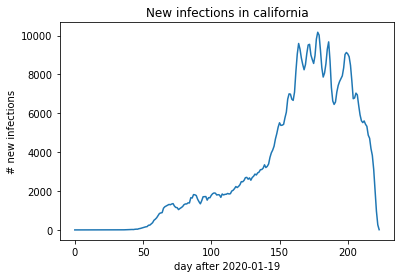

In [17]:
plt.plot(df["new_cases"])
plt.xlabel("day after {}".format(df["date"][0]))
plt.ylabel("# new infections")
plt.title("New infections in {}".format(region));

# Converting data inputs to PyTorch tensors

In [45]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [47]:
full_metadata = pd.read_csv("../gisaid/metadata.tsv", sep="\t")
metadata = full_metadata[full_metadata["strain"].isin([x.name for x in phylogeny_newick.get_terminals()])]
metadata["date"] = pd.to_datetime(metadata["date"])
metadata['decimal_date'] = metadata["date"].apply(toYearFraction)

<ipython-input-47-7d42be9dc88b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["date"] = pd.to_datetime(metadata["date"])
<ipython-input-47-7d42be9dc88b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['decimal_date'] = metadata["date"].apply(toYearFraction)


In [50]:
last_tip_date = metadata["decimal_date"].max()

In [54]:
leaf_times, coal_times = dist.coalescent.bio_phylo_to_times(phylogeny_newick)
shift = last_tip_date-max(leaf_times)
leaf_times = leaf_times + shift
coal_times = coal_times + shift

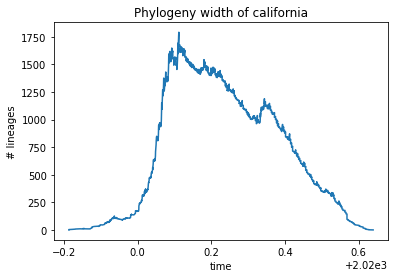

In [55]:
times = torch.cat([coal_times, leaf_times])
signs = torch.cat([-torch.ones_like(coal_times), torch.ones_like(leaf_times)])
times, index = times.sort(0)
signs = signs[index]
lineages = signs.flip([0]).cumsum(0).flip([0])

plt.plot(times, lineages)
plt.xlabel("time")
plt.ylabel("# lineages")
plt.title("Phylogeny width of {}".format(region));

In [61]:
model = SuperspreadingSEIRModel(population=int(4e7),
                                incubation_time=5.5,
                                recovery_time=14.,
                                data=new_cases,
                                leaf_times=leaf_times,
                                coal_times=coal_times)

mcmc = model.fit_mcmc(num_samples=200,
                 haar_full_mass=7)

INFO 	 Running inference...
Sample: 100%|██████████| 400/400 [00:19, 20.64it/s, step size=2.78e-05, acc. prob=0.521]


In [57]:
mcmc.summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
              R0      3.06      0.00      3.06      3.05      3.07      2.68      2.28
               k      0.81      0.01      0.81      0.80      0.83      2.55      2.59
             rho      0.00      0.00      0.00      0.00      0.01      2.90      2.06
  auxiliary[0,0] 39999999.50      0.00 39999999.50 39999999.50 39999999.51      6.24      1.03
  auxiliary[0,1] 39999997.77      0.01 39999997.77 39999997.76 39999997.78      2.67      2.26
  auxiliary[0,2] 39999996.10      0.01 39999996.10 39999996.09 39999996.11      2.51      3.91
  auxiliary[0,3] 39999989.80      0.01 39999989.80 39999989.78 39999989.83      3.39      1.69
  auxiliary[0,4] 39999988.58      0.03 39999988.60 39999988.53 39999988.61      2.79      2.19
  auxiliary[0,5] 39999984.85      0.01 39999984.85 39999984.83 39999984.88      4.86      1.16
  auxiliary[0,6] 39999976.59      0.03 39999976.59 39999976.54 39999976.65      3